In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub
import os
import shutil

# Define the paths for the new directories
datasets_folder_path = '/content/drive/My Drive/Datasets'
PNEUMONIA_Xray = os.path.join(datasets_folder_path, 'PNEUMONIA-Chest X-Ray Image Classification')

# Create the directories
os.makedirs(PNEUMONIA_Xray, exist_ok=True)

# Download latest version
path = kagglehub.dataset_download("vivek468/beginner-chest-xray-image-classification")
print("Dataset files downloaded to:", PNEUMONIA_Xray)

print("Path to dataset files:", path)

# Move the downloaded files to the 'brain tumor dataset' folder
for filename in os.listdir(path):
    shutil.move(os.path.join(path, filename), os.path.join(PNEUMONIA_Xray, filename))



print("Path to dataset files:", path)

100%|██████████| 2.08G/2.08G [01:52<00:00, 19.8MB/s]

Extracting files...


Dataset files downloaded to: /content/drive/My Drive/Datasets/PNEUMONIA-Chest X-Ray Image Classification
Path to dataset files: /root/.cache/kagglehub/datasets/vivek468/beginner-chest-xray-image-classification/versions/1
Path to dataset files: /root/.cache/kagglehub/datasets/vivek468/beginner-chest-xray-image-classification/versions/1


In [3]:
! pip install torchviz
! pip install split-folders
! pip install torchsummary
! pip install imblearn

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=16e8e77aff11d735377332caccee0dc71c51233515b9089bee3053248ce5390b
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


#import Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
from torchsummary import summary
import splitfolders
import torch.nn.functional as F
import pathlib
from torch import optim
import torchvision.models as models
from torchviz import make_dot
from torchvision import models
from torchviz import make_dot
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#import zipfile

#Bulid DataFrame and Data Analytics

In [5]:
import os
import pandas as pd

# Define the path to the directories
train_dir = '/content/drive/MyDrive/Datasets/PNEUMONIA-Chest X-Ray Image Classification/chest_xray/train'
test_dir = '/content/drive/MyDrive/Datasets/PNEUMONIA-Chest X-Ray Image Classification/chest_xray/test'

# Function to create a DataFrame with image paths and labels
def create_dataframe(directory):
    data = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):  # Check if it's a directory
            for file in os.listdir(label_dir):
                if file.endswith(('.png', '.jpg', '.jpeg')):  # Include image file types
                    data.append({'file_path': os.path.join(label_dir, file), 'label': label})
    return pd.DataFrame(data)

# Create DataFrames for train and test datasets
train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

# Print out the first few rows of the DataFrames
print("Train DataFrame:")
print(train_df.head())
print("\nTest DataFrame:")
print(test_df.head())


Train DataFrame:
                                           file_path      label
0  /content/drive/MyDrive/Datasets/PNEUMONIA-Ches...  PNEUMONIA
1  /content/drive/MyDrive/Datasets/PNEUMONIA-Ches...  PNEUMONIA
2  /content/drive/MyDrive/Datasets/PNEUMONIA-Ches...  PNEUMONIA
3  /content/drive/MyDrive/Datasets/PNEUMONIA-Ches...  PNEUMONIA
4  /content/drive/MyDrive/Datasets/PNEUMONIA-Ches...  PNEUMONIA

Test DataFrame:
                                           file_path      label
0  /content/drive/MyDrive/Datasets/PNEUMONIA-Ches...  PNEUMONIA
1  /content/drive/MyDrive/Datasets/PNEUMONIA-Ches...  PNEUMONIA
2  /content/drive/MyDrive/Datasets/PNEUMONIA-Ches...  PNEUMONIA
3  /content/drive/MyDrive/Datasets/PNEUMONIA-Ches...  PNEUMONIA
4  /content/drive/MyDrive/Datasets/PNEUMONIA-Ches...  PNEUMONIA


In [6]:
len(train_df)

7315

In [7]:
train_df.shape

(7315, 2)

In [8]:
len(test_df)

620

In [9]:
test_df.shape

(620, 2)

In [10]:
train_df.head()

,file_path,label
0,/content/drive/MyDrive/Datasets/PNEUMONIA-Ches...,PNEUMONIA
1,/content/drive/MyDrive/Datasets/PNEUMONIA-Ches...,PNEUMONIA
2,/content/drive/MyDrive/Datasets/PNEUMONIA-Ches...,PNEUMONIA
3,/content/drive/MyDrive/Datasets/PNEUMONIA-Ches...,PNEUMONIA
4,/content/drive/MyDrive/Datasets/PNEUMONIA-Ches...,PNEUMONIA


In [11]:
train_df.tail()

,file_path,label
7310,/content/drive/MyDrive/Datasets/PNEUMONIA-Ches...,NORMAL
7311,/content/drive/MyDrive/Datasets/PNEUMONIA-Ches...,NORMAL
7312,/content/drive/MyDrive/Datasets/PNEUMONIA-Ches...,NORMAL
7313,/content/drive/MyDrive/Datasets/PNEUMONIA-Ches...,NORMAL
7314,/content/drive/MyDrive/Datasets/PNEUMONIA-Ches...,NORMAL


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7315 entries, 0 to 7314
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  7315 non-null   object
 1   label      7315 non-null   object
dtypes: object(2)
memory usage: 114.4+ KB


In [13]:
train_df.describe()

,file_path,label
count,7315,7315
unique,7315,2
top,/content/drive/MyDrive/Datasets/PNEUMONIA-Ches...,PNEUMONIA
freq,1,3883


In [14]:
train_label_counts = train_df['label'].value_counts()
test_label_counts = test_df['label'].value_counts()

In [15]:
train_df.isnull().sum()

,0
file_path,0
label,0


In [16]:
train_df_copy = copy.deepcopy(train_df)
test_df_copy = copy.deepcopy(test_df)

In [17]:
train_df.duplicated().sum()

0

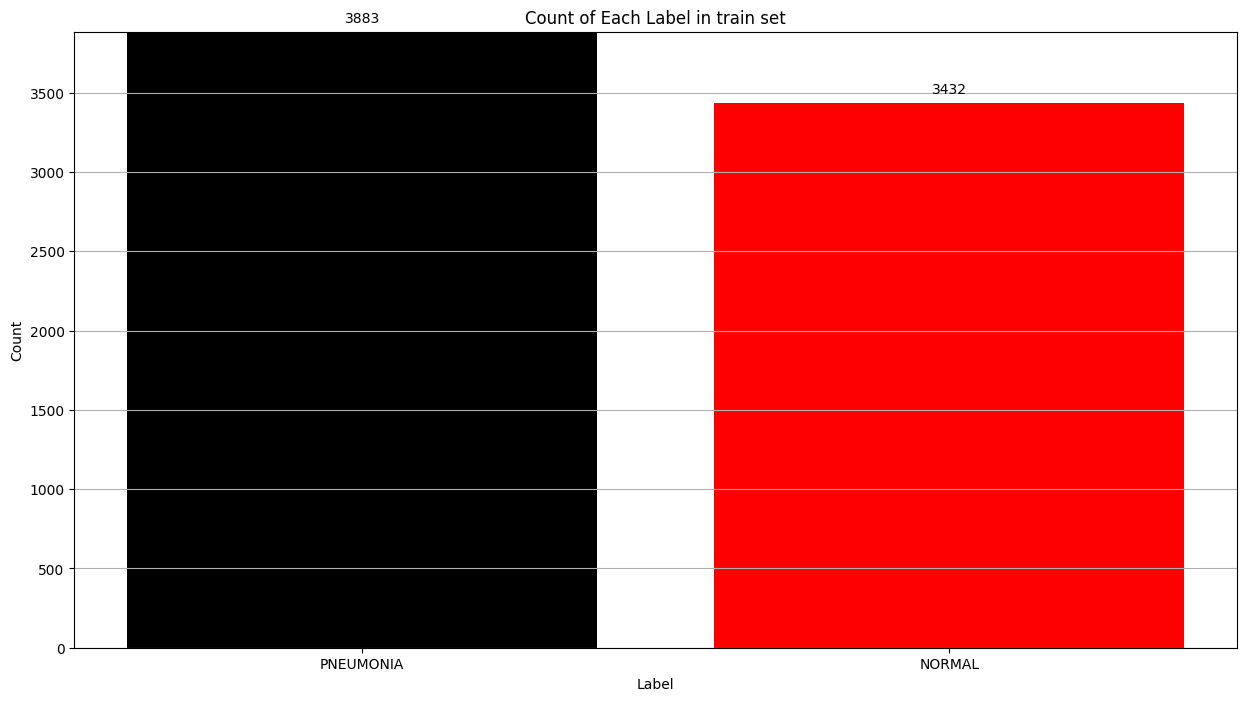

In [18]:
# Define a color for each label
colors = {
    'NORMAL': 'red',
    'PNEUMONIA': 'black'
}

# Create the plot
plt.figure(figsize=(15, 8))
bars = plt.bar(train_label_counts.index, train_label_counts.values, color=[colors[label] for label in train_label_counts.index])

# Set y-axis limit
plt.ylim(0, train_label_counts.max() + 1)

# Annotate bars with their heights
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # Offset text slightly above the bar
                 textcoords='offset points',
                 ha='center',
                 va='bottom')

# Show the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Each data in train set')
plt.grid(axis='y')
plt.show()


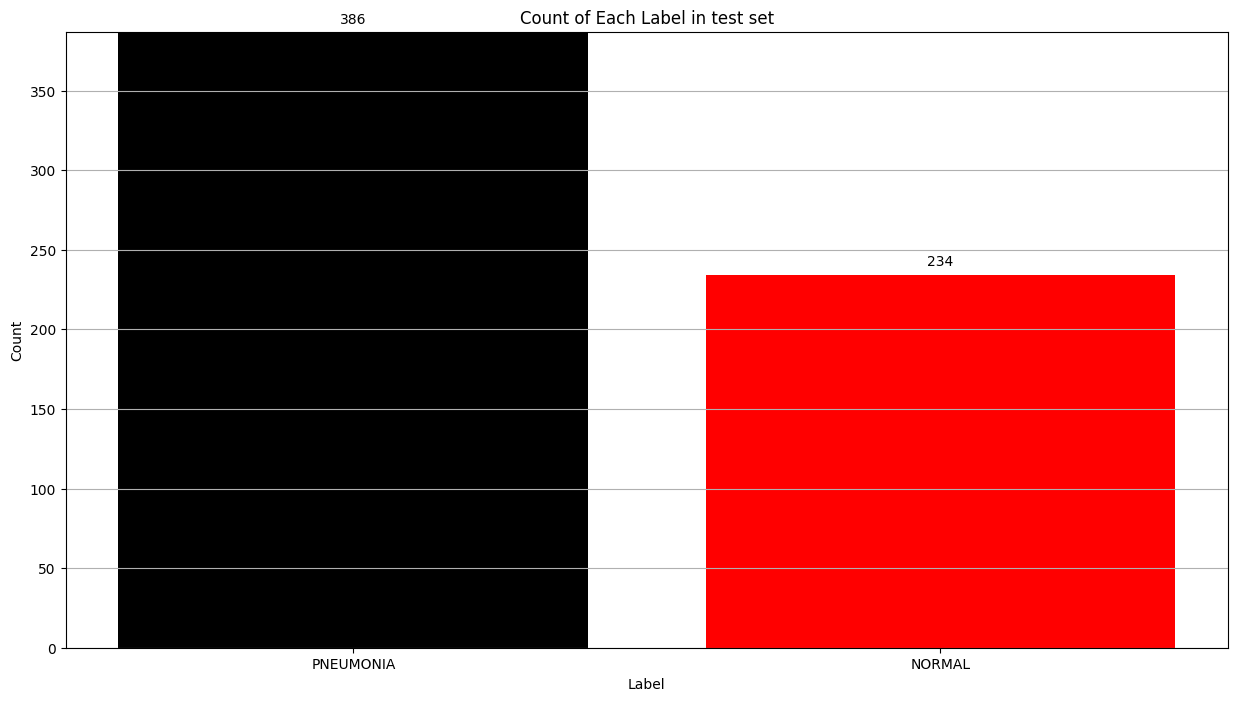

In [19]:
# Define a color for each label
colors = {
    'NORMAL': 'red',
    'PNEUMONIA': 'black'
}

# Create the plot
plt.figure(figsize=(15, 8))
bars = plt.bar(test_label_counts.index, test_label_counts.values, color=[colors[label] for label in test_label_counts.index])

# Set y-axis limit
plt.ylim(0, test_label_counts.max() + 1)

# Annotate bars with their heights
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # Offset text slightly above the bar
                 textcoords='offset points',
                 ha='center',
                 va='bottom')

# Show the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Each Label in test set')
plt.grid(axis='y')
plt.show()


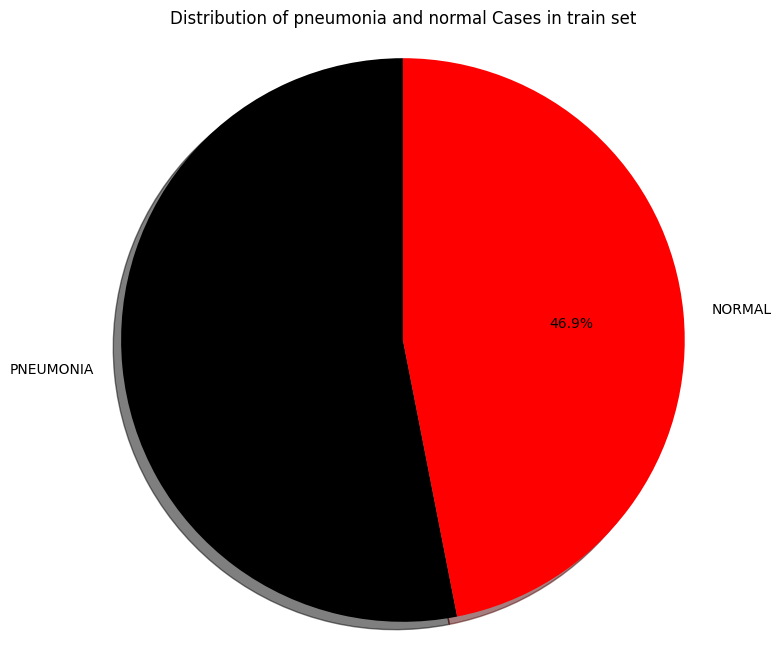

In [20]:
# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(train_label_counts,
        labels=train_label_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=['black', 'red'],  # Specify colors for each label
        shadow=True)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.title('Distribution of pneumonia and normal Cases in train set')
plt.show()


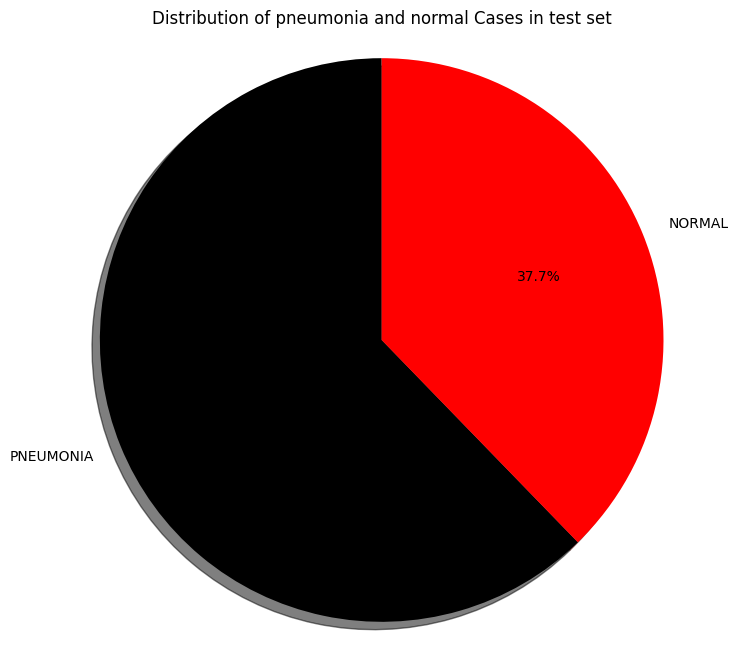

In [21]:
# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(test_label_counts,
        labels=test_label_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=['black', 'red'],  # Specify colors for each label
        shadow=True)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.title('Distribution of pneumonia and normal Cases in test set')
plt.show()


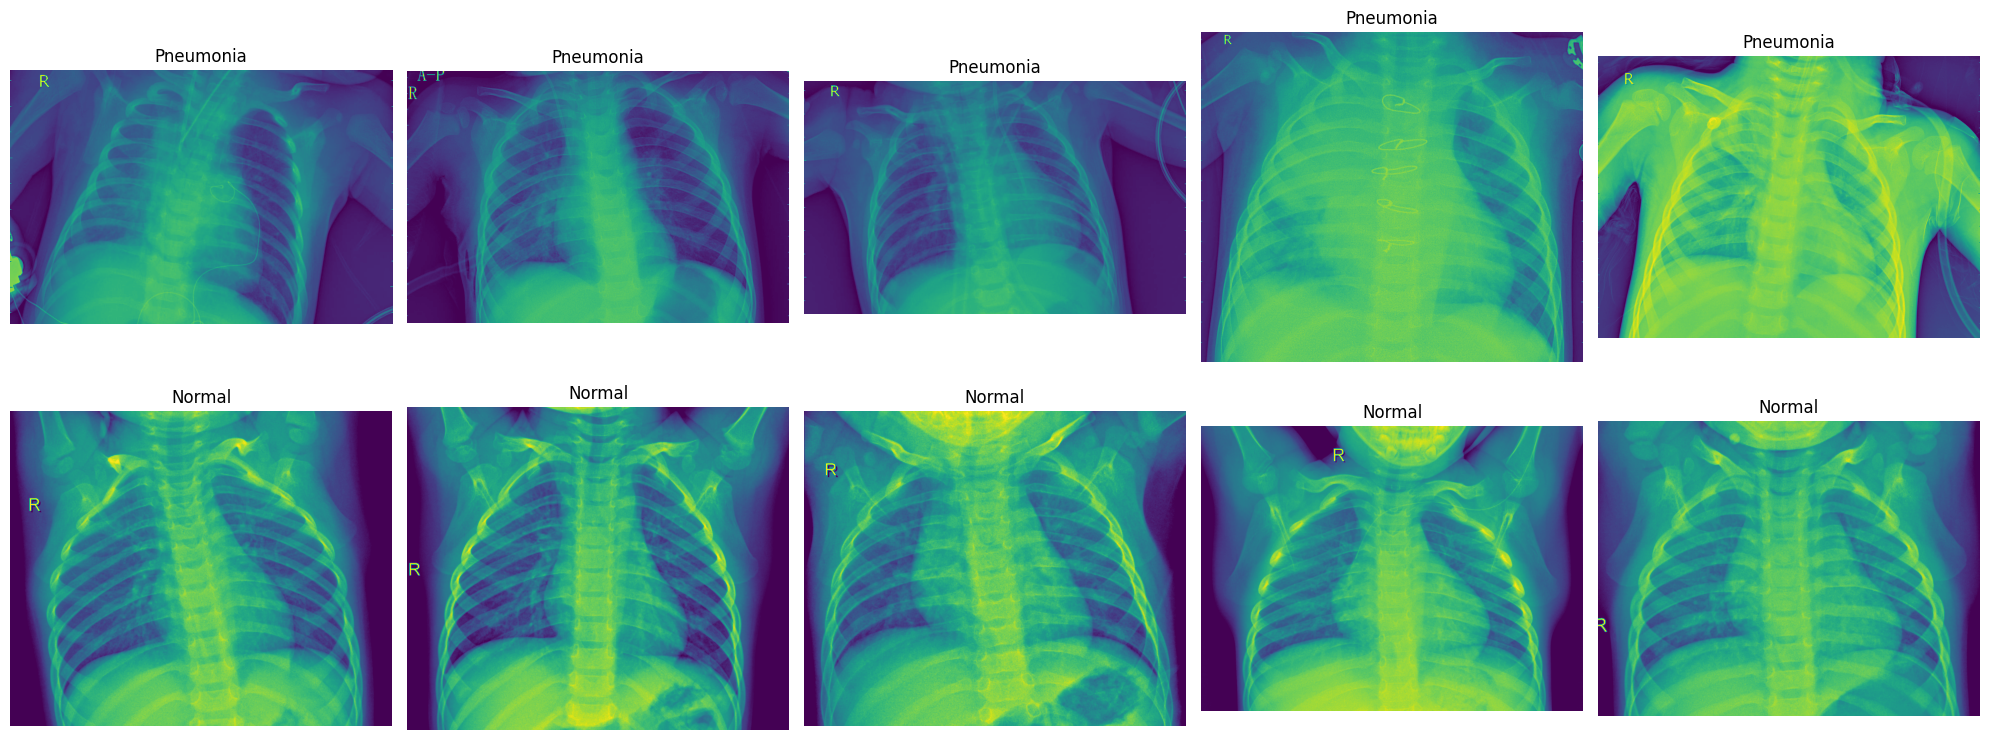

In [22]:
# Separate images by class
pneumonia_images = train_df[train_df['label'] == 'PNEUMONIA']['file_path'].values
normal_images = train_df[train_df['label'] == 'NORMAL']['file_path'].values

# Randomly sample 5 images from each category
pneumonia_sample = np.random.choice(pneumonia_images, min(5, len(pneumonia_images)), replace=False)
normal_sample = np.random.choice(normal_images, min(5, len(normal_images)), replace=False)

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Display malignant images
for ax, img_path in zip(axes[0], pneumonia_sample):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Pneumonia')

# Display benign images
for ax, img_path in zip(axes[1], normal_sample):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Normal')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [23]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(train_df[['file_path']],
train_df['label'])
train_df_resampled = pd.DataFrame(X_resampled, columns=['file_path'])
train_df_resampled['label'] = y_resampled
print("\nClass distribution after oversampling:")
print(train_df_resampled['label'].value_counts())


Class distribution after oversampling:
label
PNEUMONIA    3883
NORMAL       3883
Name: count, dtype: int64


In [24]:
train_resampled_label_counts = train_df_resampled['label'].value_counts()

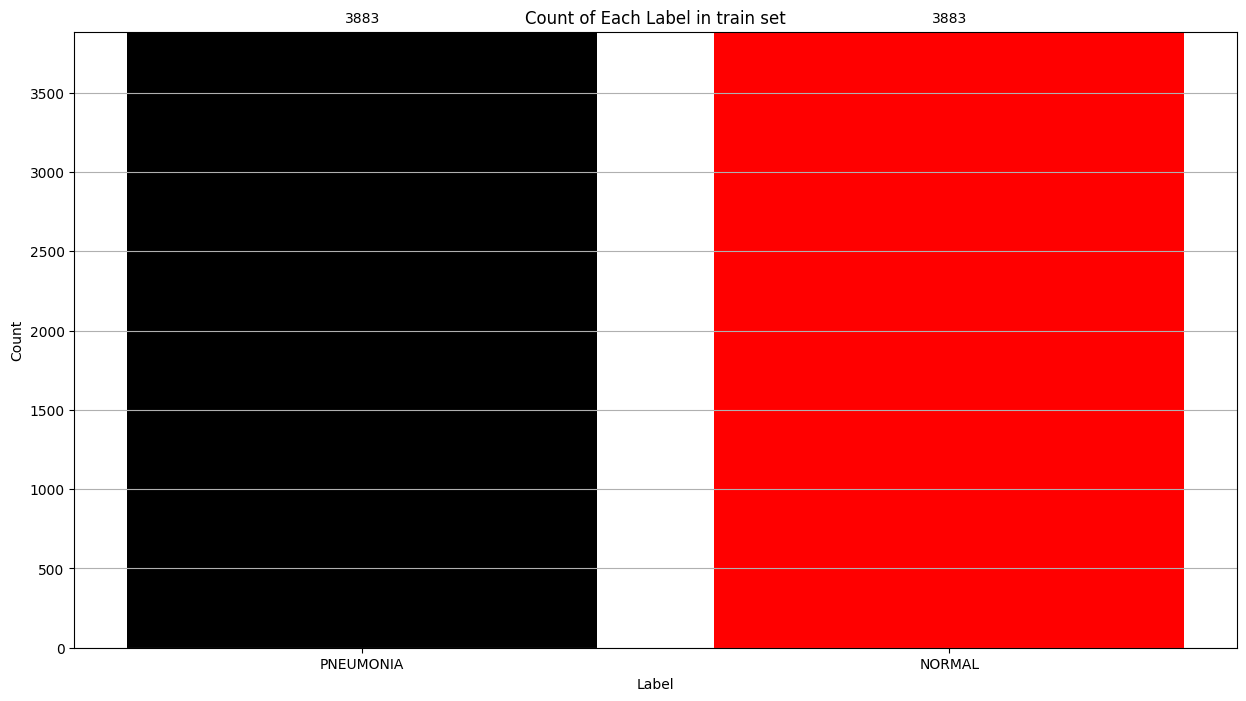

In [25]:
# Define a color for each label
colors = {
    'NORMAL': 'red',
    'PNEUMONIA': 'black'
}

# Create the plot
plt.figure(figsize=(15, 8))
bars = plt.bar(train_resampled_label_counts.index, train_resampled_label_counts.values, color=[colors[label] for label in train_resampled_label_counts.index])

# Set y-axis limit
plt.ylim(0, train_resampled_label_counts.max() + 1)

# Annotate bars with their heights
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # Offset text slightly above the bar
                 textcoords='offset points',
                 ha='center',
                 va='bottom')

# Show the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Each Label in train set')
plt.grid(axis='y')
plt.show()


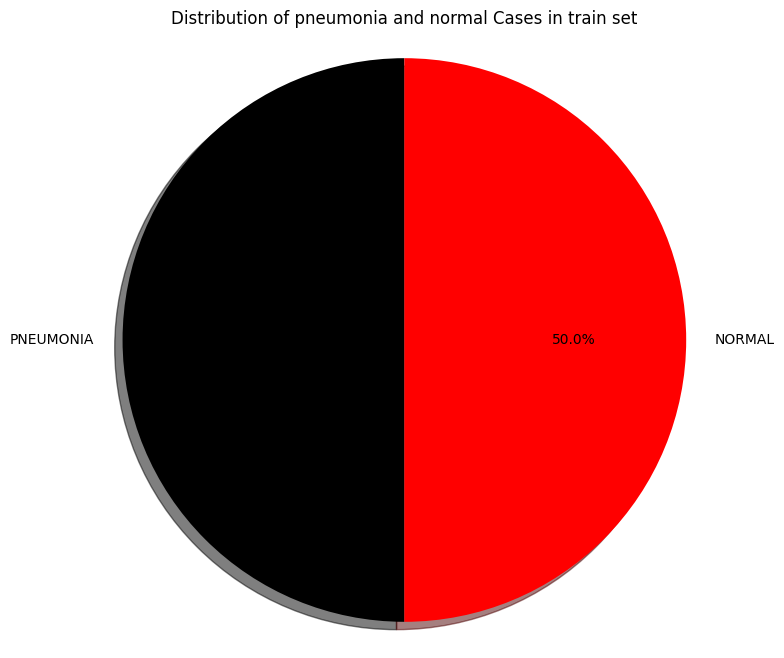

In [26]:
# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(train_resampled_label_counts,
        labels=train_resampled_label_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=['black', 'red'],  # Specify colors for each label
        shadow=True)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.title('Distribution of pneumonia and normal Cases in train set')
plt.show()


In [27]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
x_resampled, y_resampled = ros.fit_resample(test_df[['file_path']],
test_df['label'])
test_df_resampled = pd.DataFrame(x_resampled, columns=['file_path'])
test_df_resampled['label'] = y_resampled
print("\nClass distribution after oversampling:")
print(test_df_resampled['label'].value_counts())


Class distribution after oversampling:
label
PNEUMONIA    386
NORMAL       386
Name: count, dtype: int64


#Transformation and splitting

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
# Step 2: Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(p=0.5),  # Randomly flip images vertically
    transforms.RandomRotation(degrees=30),  # Randomly rotate images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, etc.
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.classes = dataframe['label'].unique()  # Store unique class names
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.classes)  # Fit the label encoder

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # Get image path
        label = self.dataframe.iloc[idx, 1]  # Get label

        # Check if the path is a file
        if not os.path.isfile(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")

        img = Image.open(img_path).convert('RGB')  # Open image and convert to RGB

        if self.transform:
            img = self.transform(img)  # Apply transformations

        # Convert label to integer and then to tensor
        label = self.label_encoder.transform([label])[0]  # Transform the label to an integer
        label = torch.tensor(label, dtype=torch.long)  # Convert to tensor

        return img, label

# Create the dataset from the resampled training DataFrame
train_dataset = CustomDataset(train_df_resampled, transform=transform)
test_dataset = CustomDataset(test_df_resampled, transform=transform)

# Step 5: Get the indices for splitting and the labels for stratification
indices = list(range(len(train_df_resampled)))
train_labels = train_df_resampled['label'].values  # Extract labels for stratification

# Split into training and validation sets
train_indices, val_indices = train_test_split(indices, test_size=0.1, random_state=42, stratify=train_labels)

# Step 8: Create training and validation subsets
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)  # Create validation subset from the original train dataset

# Step 9: Create data loaders for each dataset
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Optional: Print the sizes of the datasets
print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")


Training dataset size: 6989
Validation dataset size: 777
Test dataset size: 772


In [30]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

219
25
25


tensor(1)


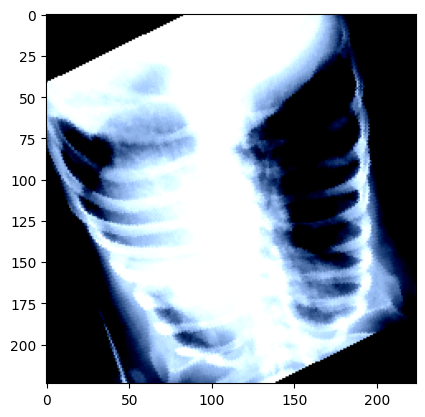

In [31]:
img, label = train_dataset[42]
plt.imshow(img.permute(1,2,0)) #convert into bgr format
print(label)

#Modeling

In [32]:
class CNNmodel(nn.Module):
    def __init__(self):
        super(CNNmodel, self).__init__()

        # Convolutional layers with increased kernel size
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # Batch normalization after conv1

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  # Batch normalization after conv2

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)  # Batch normalization after conv3

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)  # Batch normalization after conv4

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)  # Batch normalization after conv5

        self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512)  # Batch normalization after conv5

        # Max pooling layers
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

        # Activation Function
        self.leakyRelu = nn.LeakyReLU()

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 3 * 3, 1024)  # Adjusted input size based on the output of conv layers
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)

    def forward(self, x):
        # Convolutional layers with max pooling, batch normalization, and dropout
        x = self.leakyRelu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.leakyRelu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)

        x = self.leakyRelu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = self.leakyRelu(self.bn4(self.conv4(x)))
        x = self.maxpool(x)

        x = self.leakyRelu(self.bn5(self.conv5(x)))
        x = self.maxpool(x)

        x = self.leakyRelu(self.bn6(self.conv6(x)))
        x = self.maxpool(x)


        # Flatten
        out = x.view(x.size(0), -1)

        # Fully connected layers with dropout
        out = self.leakyRelu(self.fc1(out))
        out = self.dropout(out)  # Apply dropout
        out = self.leakyRelu(self.fc2(out))
        out = self.dropout(out)  # Apply dropout
        out = self.leakyRelu(self.fc3(out))
        out = self.fc4(out)


        return out


In [33]:
Model = CNNmodel()

In [34]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    # Get the current device
    current_device = torch.cuda.current_device()
    print(f"Current CUDA device: {current_device}")

    # Get the number of GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # Get the name of the GPU
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")


CUDA is not available.


In [35]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to the appropriate device
Model.to(device)

# Create a dummy input tensor on the same device
input_tensor = torch.randn(1, 3, 224, 224).to(device)

# Print model summary
summary(Model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
         LeakyReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
       BatchNorm2d-6         [-1, 32, 112, 112]              64
         LeakyReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,496
      BatchNorm2d-10           [-1, 64, 56, 56]             128
        LeakyReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
      BatchNorm2d-14          [-1, 128,

#visualize Model arcitecture

In [ ]:
# Create a dummy input
x = torch.randn(1, 3, 224, 224).to(device)  # Batch size of 1

# Get the output
y = Model(x)

# Visualize the model
dot = make_dot(y, params=dict(list(Model.named_parameters())))
dot.render("cnn_architecture3 for Pneumonia", format="png")  # Save as PNG


'cnn_architecture3 for Pneumonia.png'

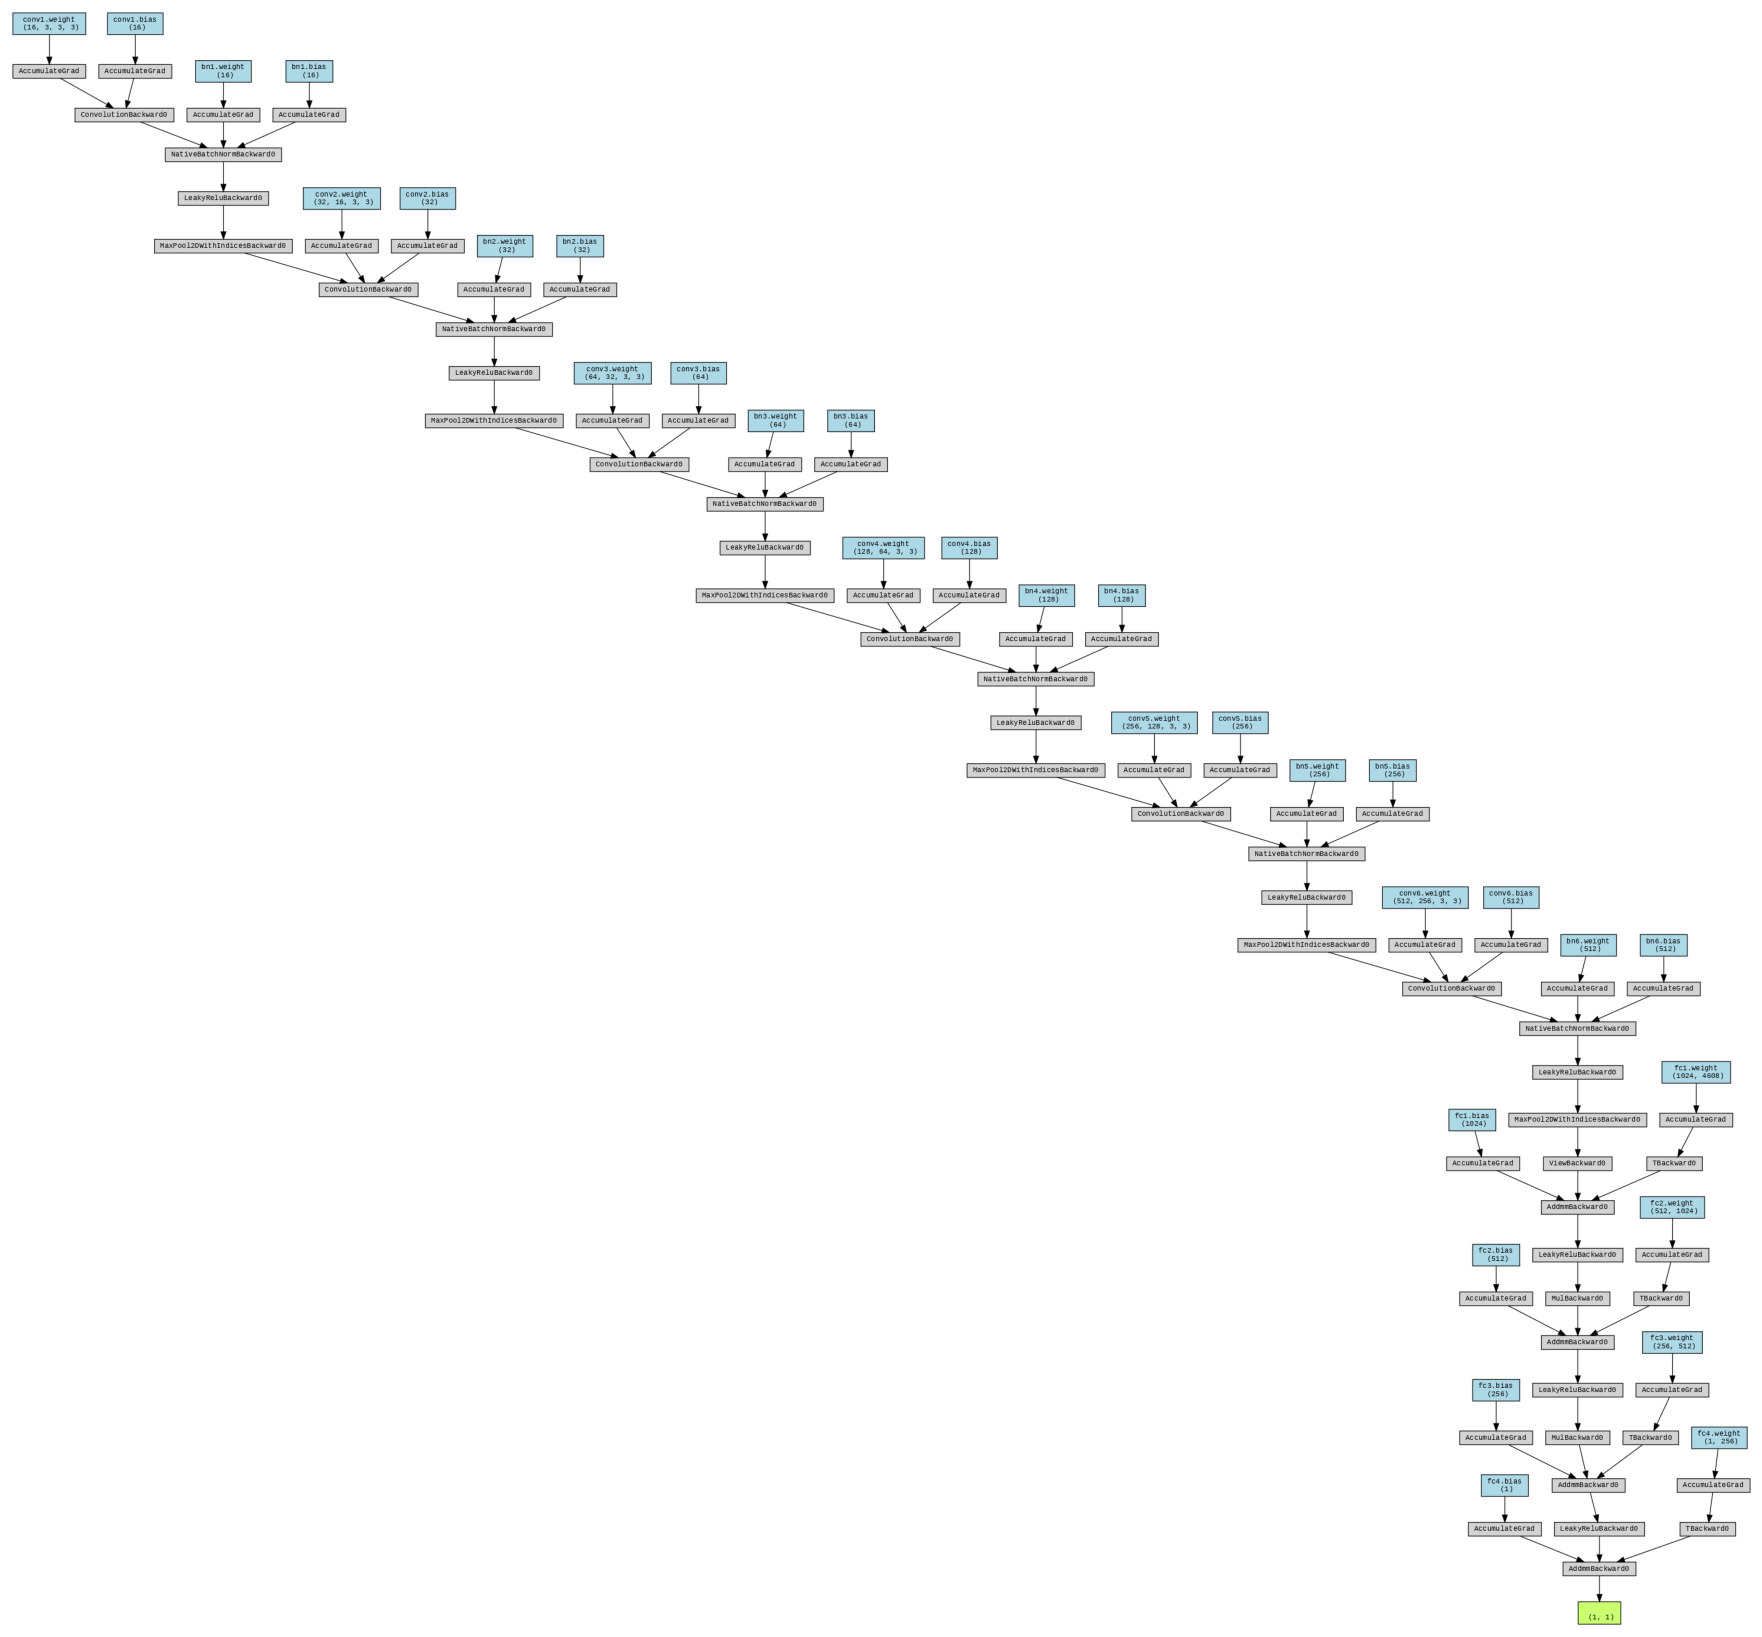

In [ ]:
# Display the image using matplotlib
img = mpimg.imread("/content/cnn_architecture3 for skincancer.png")
plt.figure(figsize=(35, 21))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [36]:
num_epoch = 10
loss_fn = nn.BCEWithLogitsLoss()
lr=0.001
optimizer = torch.optim.Adam(Model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)

In [37]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if validation loss improves
        else:
            self.counter += 1  # Increment counter if no improvement
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)


In [38]:
train_loss_list=[]
val_loss_list=[]
test_loss_list = []
acc_list=[]

best_val_loss = float('inf')  # Initialize the best validation loss
best_model_wts = None  # Variable to hold the best model weights

In [39]:
for epoch in range(num_epoch):
    train_loss = 0
    val_loss = 0
    total = 0
    correct = 0

    # Training phase
    Model.train()
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1).float()  # Ensure labels are float

        # Forward pass
        outputs = Model(images)
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Validation phase
    Model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1).float()  # Ensure labels are float

            outputs = Model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            # Get probabilities and predictions
            probabilities = torch.sigmoid(outputs)  # Apply sigmoid for evaluation
            predicted = (probabilities > 0.5).float()  # Thresholding at 0.5

            total += len(labels)
            correct += (predicted == labels).sum().item()

    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    # Calculate performance of training model
    accuracy = 100 * correct / float(total)
    train_loss_list.append(train_loss / len(train_loader))
    val_loss_list.append(val_loss / len(val_loader))
    acc_list.append(accuracy)

    print('-' * 100)
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Accuracy: {:.2f}%'.format(
        epoch + 1, num_epoch, train_loss / len(train_loader), val_loss / len(val_loader), accuracy))

    # Check if the current validation loss is the best we've seen so far
    avg_val_loss = val_loss / len(val_loader)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = Model.state_dict()
        print("Best model weights saved.")

    # Check for early stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping at epoch:", epoch + 1)
        break

# Save the best model weights to a file
if best_model_wts is not None:
    torch.save(best_model_wts, 'best_model_weights.pth')
    print("Best model weights saved to 'best_model_weights.pth'.")

----------------------------------------------------------------------------------------------------
Epoch [1/10], Train Loss: 0.3674, Val Loss: 0.3531, Accuracy: 88.16%
Best model weights saved.
----------------------------------------------------------------------------------------------------
Epoch [2/10], Train Loss: 0.2631, Val Loss: 0.2486, Accuracy: 94.34%
Best model weights saved.
----------------------------------------------------------------------------------------------------
Epoch [3/10], Train Loss: 0.2212, Val Loss: 0.4270, Accuracy: 85.46%
----------------------------------------------------------------------------------------------------
Epoch [4/10], Train Loss: 0.2120, Val Loss: 0.2211, Accuracy: 93.44%
Best model weights saved.
----------------------------------------------------------------------------------------------------
Epoch [5/10], Train Loss: 0.1978, Val Loss: 0.1607, Accuracy: 94.08%
Best model weights saved.
----------------------------------------------

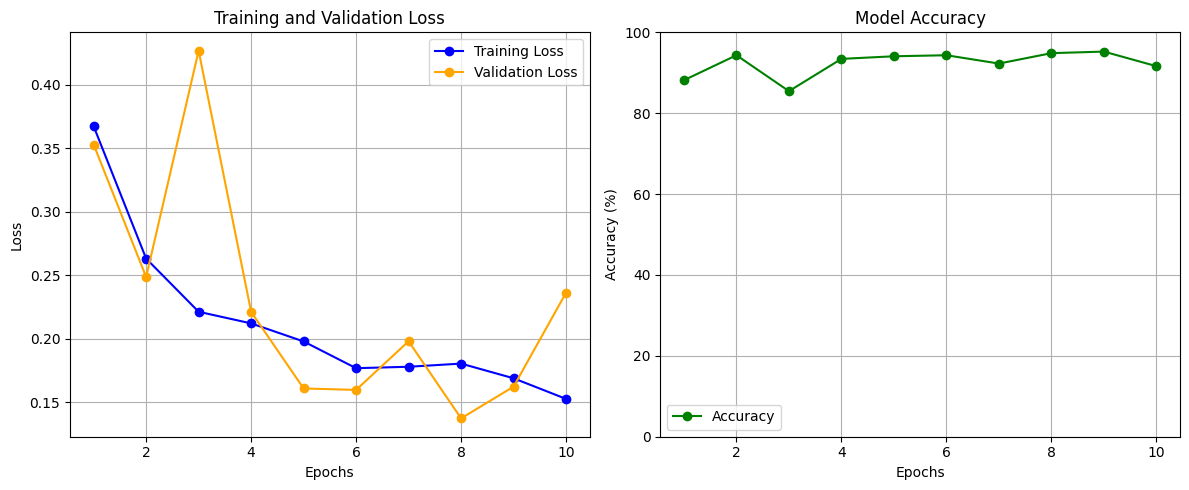

In [40]:
import matplotlib.pyplot as plt

# Assuming train_loss_list, val_loss_list, and acc_list are already populated
epochs = range(1, num_epoch + 1)

# Plotting Loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss_list, label='Validation Loss', color='orange', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_list, label='Accuracy', color='green', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Set y-axis limits to 0-100 for accuracy
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()


#Evaluation

Test Loss: 0.4942, Test Accuracy: 83.94%
Precision: 0.7610, Recall: 0.9896, F1 Score: 0.8604, ROC AUC: 0.9782


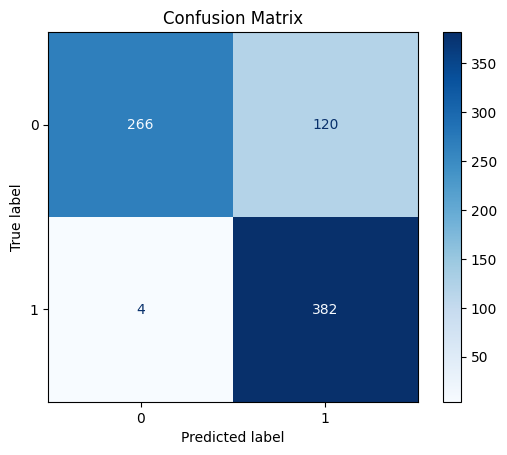

In [45]:
# Test phase
Model.eval()  # Set model to evaluation mode

# Lists to store loss and accuracy for visualization
test_loss_list = []
test_accuracy_list = []

# Lists to store predictions and labels for metrics calculation
all_labels = []
all_predictions = []
all_probabilities = []  # To store probabilities for ROC AUC

# Initialize total and correct counters
total = 0
correct = 0

# Disable gradient calculation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1).float()  # Ensure labels are float

        # Forward pass
        outputs = Model(images)
        loss = loss_fn(outputs, labels)

        # Collecting true and predicted labels
        probabilities = torch.sigmoid(outputs)  # Apply sigmoid for evaluation
        predicted = (probabilities > 0.5).float()  # Thresholding at 0.5

        all_labels.extend(labels.cpu().numpy())  # Collect true labels
        all_predictions.extend(predicted.cpu().numpy())  # Collect predicted labels
        all_probabilities.extend(probabilities.cpu().numpy())  # Collect probabilities for ROC AUC

        # Accumulate loss
        test_loss_list.append(loss.item())  # Store individual loss

        # Update total and correct counts
        total += labels.size(0)  # Number of samples in this batch
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Calculate test accuracy
test_accuracy = 100 * correct / float(total)

# Calculate average loss
average_loss = np.mean(test_loss_list)

# Print test results
print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(average_loss, test_accuracy))

# Convert lists to numpy arrays for metric calculations
all_labels = np.array(all_labels).flatten()
all_predictions = np.array(all_predictions).flatten()
all_probabilities = np.array(all_probabilities).flatten()  # Ensure this is flattened

# Calculate additional metrics
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Ensure probabilities are for the positive class for ROC AUC
roc_auc = roc_auc_score(all_labels, all_probabilities)  # Use probabilities for ROC AUC

# Print additional metrics
print('Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}, ROC AUC: {:.4f}'.format(
    precision, recall, f1, roc_auc))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Adjust labels as needed
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()



In [47]:
torch.save(Model, 'model.pth')

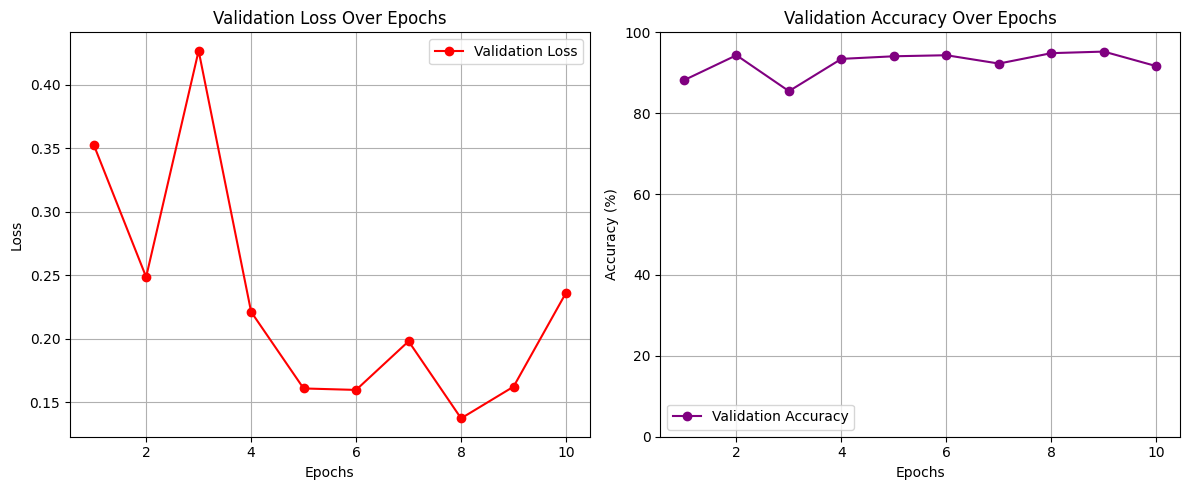

In [46]:
# Visualization of Test Loss and Accuracy
epochs = range(1, len(train_loss_list) + 1)  # Use the length of training loss list

# Plotting Test Loss and Accuracy
plt.figure(figsize=(12, 5))

# Test Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, val_loss_list, label='Validation Loss', color='red', marker='o')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Test Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_list, label='Validation Accuracy', color='purple', marker='o')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Set y-axis limits to 0-100 for accuracy
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

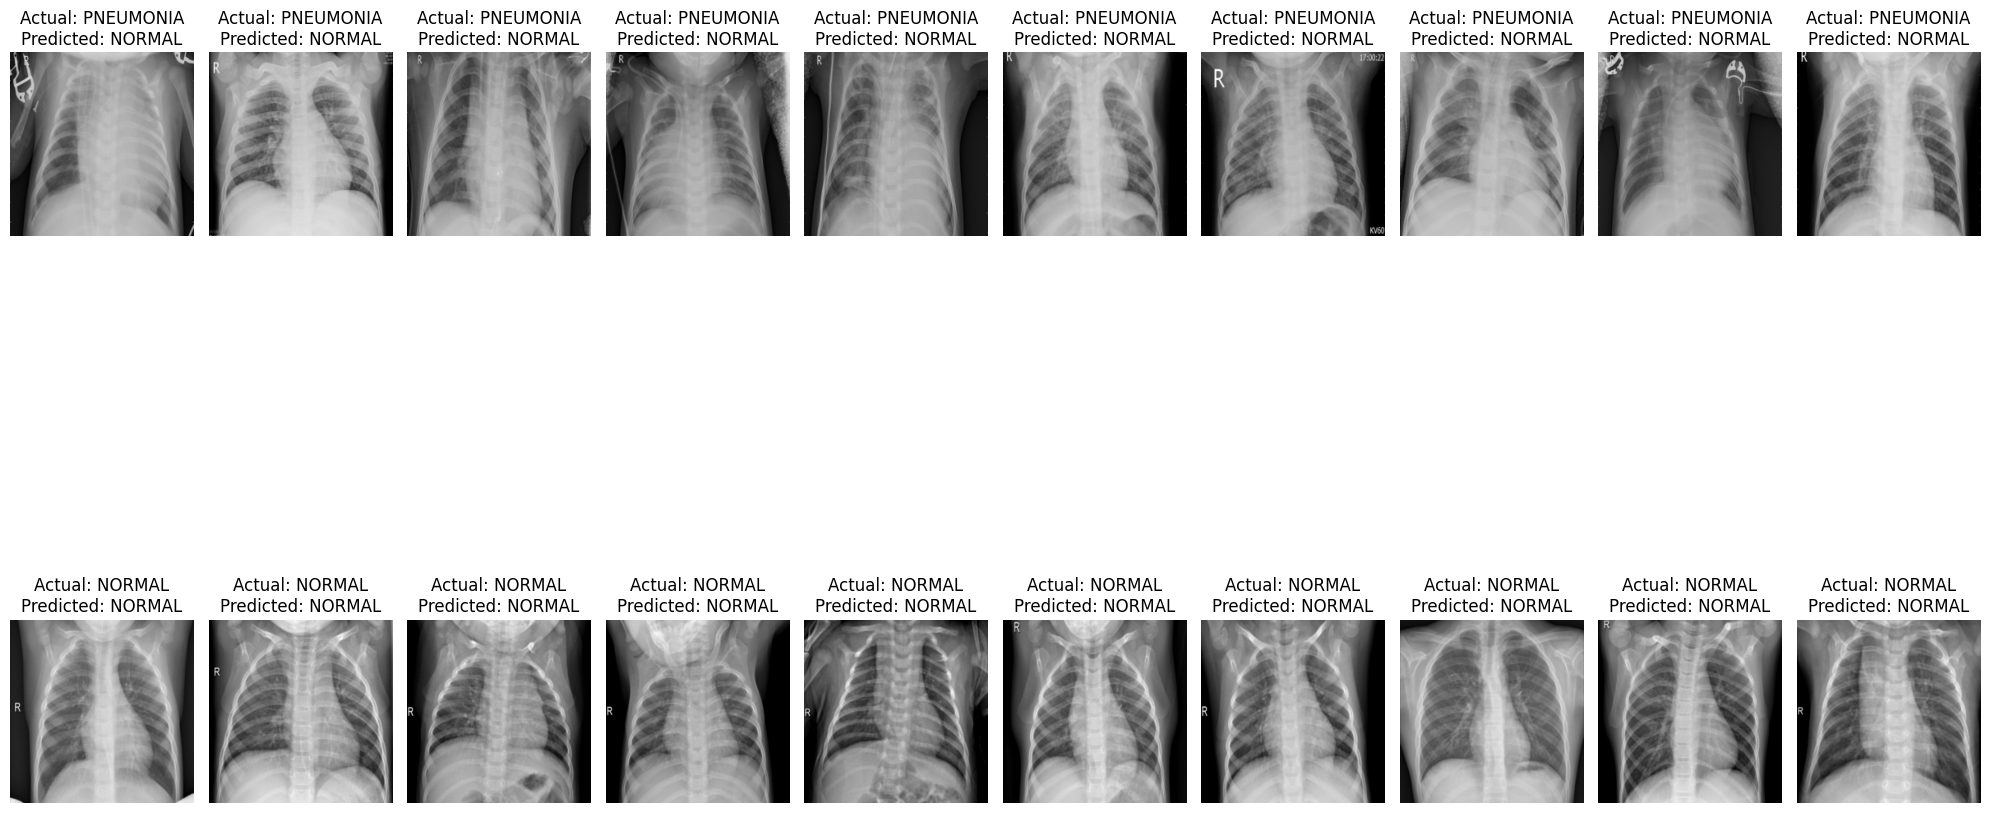

In [54]:
import random
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

def load_image(image_path, input_size=(224, 224)):
    """Load an image from a file path, resize it, and convert it to a tensor."""
    image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB format
    transform = transforms.Compose([
        transforms.Resize(input_size),  # Resize image
        transforms.ToTensor(),  # Convert image to tensor
        # Add normalization if needed (example for ImageNet)
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image)

def visualize_predictions1(model, test_set, num_samples=10, class_names=None):
    # Set model to evaluation mode
    model.eval()

    # If class_names are not provided, get them from the dataset
    if class_names is None:
        class_names = test_set['label'].unique()

    # Create a figure to hold the plots
    plt.figure(figsize=(20, 15))

    # Loop through each class
    for class_idx in range(len(class_names)):
        # Get all indices of the current class
        class_indices = test_set[test_set['label'] == class_names[class_idx]].index.tolist()

        # Randomly select num_samples indices from the class indices
        selected_indices = random.sample(class_indices, min(num_samples, len(class_indices)))  # Ensure you don't exceed available samples

        # Loop through the selected indices and plot the images
        for i, idx in enumerate(selected_indices):
            img_path = test_set.iloc[idx]['file_path']  # Adjust this if your DataFrame has a different structure
            img = load_image(img_path)  # Load image as tensor
            img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device

            # Generate model predictions
            with torch.no_grad():
                outputs = model(img)
                probabilities = torch.sigmoid(outputs)
                predicted_label = (probabilities > 0.5).float().cpu().numpy()  # Convert to numpy for easier handling
                predicted_class = int(predicted_label[0])  # Assuming binary classification

            # Plot the image
            plt.subplot(len(class_names), num_samples, class_idx * num_samples + i + 1)
            plt.imshow(img.cpu().squeeze(0).permute(1, 2, 0))  # Convert to HWC format
            plt.title(f'Actual: {class_names[class_idx]}\nPredicted: {class_names[predicted_class]}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming 'test_df' is a DataFrame with 'label' and 'file_path' columns
# You can call the function like this:
visualize_predictions1(Model, test_df)
